In [1]:
import torch
from llava.constants import X_TOKEN_INDEX, DEFAULT_X_TOKEN
from llava.conversation import conv_templates, SeparatorStyle
from llava.model.builder import load_pretrained_model
from llava.utils import disable_torch_init
from llava.mm_utils import tokenizer_X_token, get_model_name_from_path, KeywordsStoppingCriteria
import argparse, json, os
from tqdm import tqdm
import pickle
import numpy as np
from torch.nn import CosineSimilarity
from llava.utils import load_frame_embeddings, load_query_embedding, inverse_transform_sampling
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import ruptures as rpt
from scipy.signal import savgol_filter



/home/scur0554/.conda/envs/videollava/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
/home/scur0554/.conda/envs/videollava/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/scur0554/.conda/envs/videollava/lib/python3.10/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


/home/scur0554/.conda/envs/videollava/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32
[2025-05-26 13:23:30,412] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/home/scur0554/.conda/envs/videollava/lib/python3.10/site-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
/home/scur0554/.conda/envs/videollava/lib/python3.10/site-packages/torchvision/transforms/_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms' module instead.
  warnings.warn(
/home/scur0554/.conda/envs/videollava/lib/python3.10/site-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.

In [9]:


answer_prompt = {
    "multi-choice": "\nPlease directly give the best option:",
    "yes_no": "\nPlease answer yes or no:",
    "caption_matching": "\nPlease directly give the best option:",
    "captioning": ""
}

def keypoint_sampling(query_embedding, video_embeddings):
    """
    Samples 8 frame indices from video_embeddings based on cosine similarity to the query_embedding,
    using smoothed signal analysis and breakpoint detection.
    """
    # Step 1: Compute cosine similarity signal
    video_embeddings = np.array(video_embeddings)
    query_embedding = np.array(query_embedding).reshape(1, -1)
    similarity_scores = cosine_similarity(video_embeddings, query_embedding).flatten()

    # Step 2: Smooth the similarity signal
    def smooth_signal(signal, window=11, polyorder=2):
        n = len(signal)
        w = min(window, n)
        w = w if w % 2 == 1 else max(1, w - 1)
        p = min(polyorder, w - 1)
        return savgol_filter(signal, w, p) if n >= w else signal

    smoothed_signal = smooth_signal(similarity_scores)

    # Step 3: Detect breakpoints
    def find_breakpoints(signal, n_bkps=4, min_seg=5):
        if len(signal) < (n_bkps + 1) * min_seg:
            n_bkps = max(0, (len(signal) // min_seg) - 1)
        algo = rpt.Dynp(model="l1", min_size=min_seg).fit(signal)
        bkps = algo.predict(n_bkps=n_bkps)
        return bkps[:-1]  # drop final (len(signal))

    bkps = find_breakpoints(smoothed_signal)

    # Step 4: Find most distinct points around each breakpoint
    def find_max_diff_points(signal, bkps, half_width=5):
        results = []
        for bkpt in bkps:
            start = max(0, bkpt - half_width)
            end = min(len(signal), bkpt + half_width + 1)
            seg = signal[start:end]
            if len(seg) >= 2:
                i_min, i_max = np.argmin(seg), np.argmax(seg)
                idx1 = start + i_min
                idx2 = start + i_max
                if idx1 != idx2:
                    results.extend(sorted([idx1, idx2]))
                else:  # fallback: choose two neighbors
                    if idx1 + 1 < len(signal):
                        results.extend(sorted([idx1, idx1 + 1]))
        return results

    candidate_indices = find_max_diff_points(smoothed_signal, bkps)

    # Step 5: Select top 8 unique indices by their similarity to the query
    unique_indices = list(dict.fromkeys(candidate_indices))  # preserve order
    if len(unique_indices) < 8:
        # Fallback: fill remaining from top global similarities
        sorted_by_similarity = np.argsort(-similarity_scores)
        for idx in sorted_by_similarity:
            if idx not in unique_indices:
                unique_indices.append(idx)
            if len(unique_indices) == 8:
                break
    else:
        unique_indices = unique_indices[:8]

    return sorted(unique_indices)



# Gradient based sampling by Caspar
def select_gradient_boundaries(query_embedding, video_embeddings, n_samples=8, 
                           num_gradient_points=4, min_distance=15, boundary_offset=5, 
                           window_size=5):
    """
    Selects frames around the points with largest gradient in similarity curve.
    
    Args:
        query_embedding (tensor): CLIP embedding of the text query
        video_embeddings (tensor): CLIP embeddings of video frames
        n_samples (int): Total number of frames to return
        num_gradient_points (int): Number of gradient points to identify (default: 4)
        min_distance (int): Minimum distance between gradient points (default: 15)
        boundary_offset (int): Number of frames to look before/after gradient points (default: 5)
        window_size (int): Size of smoothing window (default: 5)
        
    Returns:
        sampled_indices (np.ndarray): Indices of sampled frames
    """
    from scipy.ndimage import gaussian_filter1d
    
    # Compute similarity scores
    cosine_sim = CosineSimilarity(dim=1)
    similarity_scores = cosine_sim(video_embeddings, query_embedding).numpy()
    
    # Apply smoothing to reduce noise
    smoothed = gaussian_filter1d(similarity_scores, sigma=window_size / 3.0)
    
    # Calculate gradient
    gradient = np.gradient(smoothed)
    abs_gradient = np.abs(gradient)
    
    # Sort indices by gradient magnitude (descending)
    sorted_indices = np.argsort(-abs_gradient)
    
    # Select largest gradient points with minimum distance constraint
    gradient_points = []
    for idx in sorted_indices:
        # Check if this point is far enough from already selected points
        if all(abs(idx - point) >= min_distance for point in gradient_points):
            gradient_points.append(idx)
            
        # Stop once we have enough points
        if len(gradient_points) >= num_gradient_points:
            break
    
    # For each gradient point, select frames before and after
    selected_frames = []
    for point in gradient_points:
        # Add frame before the gradient point (if within bounds)
        before_idx = max(0, point - boundary_offset)
        selected_frames.append(before_idx)
        
        # Add frame after the gradient point (if within bounds)
        after_idx = min(len(similarity_scores) - 1, point + boundary_offset)
        selected_frames.append(after_idx)
    
    # If we have more frames than requested, trim the list
    if len(selected_frames) > n_samples:
        selected_frames = selected_frames[:n_samples]
    
    # If we have fewer frames than requested, add frames using similarity scores
    if len(selected_frames) < n_samples:
        # Create a mask to exclude already selected frames
        mask = np.ones(len(similarity_scores), dtype=bool)
        for idx in selected_frames:
            mask[idx] = False
        
        # Get the remaining frames and their similarity scores
        remaining_indices = np.arange(len(similarity_scores))[mask]
        remaining_scores = similarity_scores[mask]
        
        if len(remaining_indices) > 0:
            # Sort by similarity score (descending)
            sorted_remaining = remaining_indices[np.argsort(-remaining_scores)]
            
            # Add the frames with highest similarity scores
            additional_needed = n_samples - len(selected_frames)
            additional_frames = sorted_remaining[:additional_needed]
            
            selected_frames.extend(additional_frames)
    
    # Remove any duplicates while preserving order
    unique_frames = []
    for idx in selected_frames:
        if idx not in unique_frames:
            unique_frames.append(idx)
    
    return np.array(unique_frames), gradient_points


    
def dani_sampling(query_embedding, video_embeddings, n_samples=8, alpha=3, oversampling_factor=3, lambda_param=0.5):
    """
    Performs inverse transform sampling with MMR-based diversification.

    Args:
        query_embedding (tensor): Query embedding
        video_embeddings (tensor): Video frame embeddings
        n_samples (int): Number of frames to sample
        alpha (float): Sharpness for score shaping
        oversampling_factor (int): Controls how many candidates to sample
        lambda_param (float): MMR trade-off between relevance and diversity

    Returns:
        sampled_indices (np.ndarray): Final selected frame indices
    """
    cosine_sim1 = CosineSimilarity(dim=1)
    cosine_sim0 = CosineSimilarity(dim=0)

    # Step 1: Inverse Transform Sampling
    similarity_scores = cosine_sim1(video_embeddings, query_embedding).numpy()
    min_score, max_score = np.min(similarity_scores), np.max(similarity_scores)
    norm_scores = (similarity_scores - min_score) / (max_score - min_score)
    refined_scores = norm_scores ** alpha
    pdf = refined_scores / np.sum(refined_scores)
    cdf = np.cumsum(pdf)

    num_candidates = n_samples * oversampling_factor
    uniform_targets = np.linspace(0, 1, num_candidates, endpoint=False) + (0.5 / num_candidates)
    sampled_indices = np.searchsorted(cdf, np.clip(uniform_targets, 0, 1), side='left')
    sampled_indices = np.minimum(sampled_indices, len(similarity_scores) - 1)

    candidate_indices = np.unique(sampled_indices)
    candidate_embeddings = video_embeddings[candidate_indices]
    candidate_similarities = similarity_scores[candidate_indices]

    # Step 2: MMR Diversification
    selected = []
    selected_mask = np.zeros(len(candidate_indices), dtype=bool)

    for _ in range(n_samples):
        mmr_scores = []
        for i in range(len(candidate_indices)):
            if selected_mask[i]:
                continue
            relevance = candidate_similarities[i]
            diversity = 0
            if selected:
                diversity = max([
                    cosine_sim0(candidate_embeddings[i], candidate_embeddings[j]).item()
                    for j in selected
                ])
            mmr = lambda_param * relevance - (1 - lambda_param) * diversity
            mmr_scores.append((mmr, i))
        _, best_idx = max(mmr_scores)
        selected.append(best_idx)
        selected_mask[best_idx] = True

    final_indices = np.array([candidate_indices[i] for i in selected])
    return np.sort(final_indices)
    
def uniform_sampling(video_embeddings):
    n = len(video_embeddings)
    array = np.linspace(0, n-1, 8)
    array = np.round(array).astype(int)
    return array

cosine_sim = CosineSimilarity(dim=1)

def inverse_transform_sampling(query_embedding, video_embeddings, n_samples, alpha=3):
    """
    Performs inverse transform sampling based on similarity scores.

    Args:
        similarity_scores (np.ndarray): 1D array of frame-query similarity scores s_i
        n_samples (int): Number of frames to sample
        alpha (float): Sharpness parameter (typically 2.5 <= alpha <= 3.5)

    Returns:
        sampled_indices (np.ndarray): Indices of sampled frames
        cdf (np.ndarray): The calculated cumulative distribution function.
                          (Added this return for easier reuse if needed)
    """
    similarity_scores = cosine_sim(query_embedding, video_embeddings)

    min_score = np.min(similarity_scores)
    max_score = np.max(similarity_scores)
    
    norm_scores = (similarity_scores - min_score) / (max_score - min_score)
    refined_scores = norm_scores ** alpha

    sum_refined_scores = np.sum(refined_scores)
    pdf = refined_scores / sum_refined_scores 
    cdf = np.cumsum(pdf)
    
    uniform_targets = np.linspace(0, 1, n_samples, endpoint=False) + (1.0 / (2 * n_samples))
    uniform_targets = np.clip(uniform_targets, 0, 1)

    sampled_indices = np.searchsorted(cdf, uniform_targets, side='left')
    sampled_indices = np.minimum(sampled_indices, len(similarity_scores) - 1)

    return sampled_indices



In [10]:

answer_prompt = {
    # "multi-choice": "\nBest Option:",     # The old version
    "multi-choice": "\nPlease directly give the best option:",
    "yes_no": "\nPlease answer yes or no:",
    # "caption_matching": "\nBest Option:",     #The old version
    "caption_matching": "\nPlease directly give the best option:",
    "captioning": ""    # The answer "Generated Caption:" is already contained in the question
}

import matplotlib.pyplot as plt
import numpy as np

from PIL import Image


import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

def plot_cosine_similarity_with_frames(video_id, similarities, mmr_indices, mmr_images, uniform_indices, uniform_images, save_path=None):
    """
    Plot: Cosine similarity curve with sampled frame indices,
    and two rows of sampled frames (MMR and Uniform) below, labeled on the left.
    """
    n_imgs = len(mmr_images)
    fig = plt.figure(figsize=(2.5 * n_imgs, 9))
    gs = gridspec.GridSpec(3, n_imgs, height_ratios=[3, 1, 1], hspace=0.25)

    # --- Cosine similarity plot (top, spans all columns) ---
    ax1 = plt.subplot(gs[0, :])
    ax1.plot(similarities, label="Cosine Similarity", color="#1f77b4", linewidth=2.5)
    for i, idx in enumerate(mmr_indices):
        ax1.axvline(x=idx, color="#d62728", linestyle="--", linewidth=2,
                    label="MMR Sampled Frame" if i == 0 else None)
        # ax1.axvline(x=uniform_indices[i], color="black", linestyle="--", linewidth=2,
        #             label="Uniform Sampled Frame" if i == 0 else None, alpha=0.5)
    ax1.set_xlabel("Frame Index", fontsize=16)
    ax1.set_ylabel("Cosine Similarity", fontsize=16)
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.grid(True, linestyle=':', linewidth=1, alpha=0.7)
    ax1.set_title(f"Cosine Similarities of Query vs Frame Embeddings", fontsize=20, pad=10)
    handles, labels = ax1.get_legend_handles_labels()
    if "Sampled Frame" in labels:
        by_label = dict(zip(labels, handles))
        ax1.legend(
            by_label.values(), by_label.keys(),
            fontsize=16, loc='upper right',
            frameon=True, facecolor='white', edgecolor='black', frame_alpha=0.8
        )
    else:
        ax1.legend(fontsize=16, loc='upper right', frameon=True, facecolor='white', edgecolor='black')

    # --- First row: MMR images ---
    for i, img in enumerate(mmr_images):
        ax_img = plt.subplot(gs[1, i])
        ax_img.imshow(img)
        ax_img.axis("off")
        ax_img.set_title(f"{mmr_indices[i]}", fontsize=15, pad=6)
        ax_img.title.set_position([.5, -0.25])
        if i == 0:
            ax_img.text(-0.1, 0.5, "Gradient-based", fontsize=18,
                        va='center', ha='right', transform=ax_img.transAxes, rotation=90)

    # --- Second row: Uniform images ---
    for i, img in enumerate(uniform_images):
        ax_img = plt.subplot(gs[2, i])
        ax_img.imshow(img)
        ax_img.axis("off")
        ax_img.set_title(f"{uniform_indices[i]}", fontsize=15, pad=6)
        ax_img.title.set_position([.5, -0.25])
        if i == 0:
            ax_img.text(-0.1, 0.5, "Uniform", fontsize=18,
                        va='center', ha='right', transform=ax_img.transAxes, rotation=90)

    fig.text(
        0.055, 0.25, "Sampling Method", fontsize=18, fontweight='bold',
        va='center', ha='center', rotation=90
    )

    plt.tight_layout()
    plt.subplots_adjust(left=0.09, right=0.98, top=0.92, bottom=0.08, hspace=0.1)
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        plt.show()
        plt.close(fig)
    else:
        plt.show()
    

/scratch-local/62814/ipykernel_1198899/3643680331.py:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


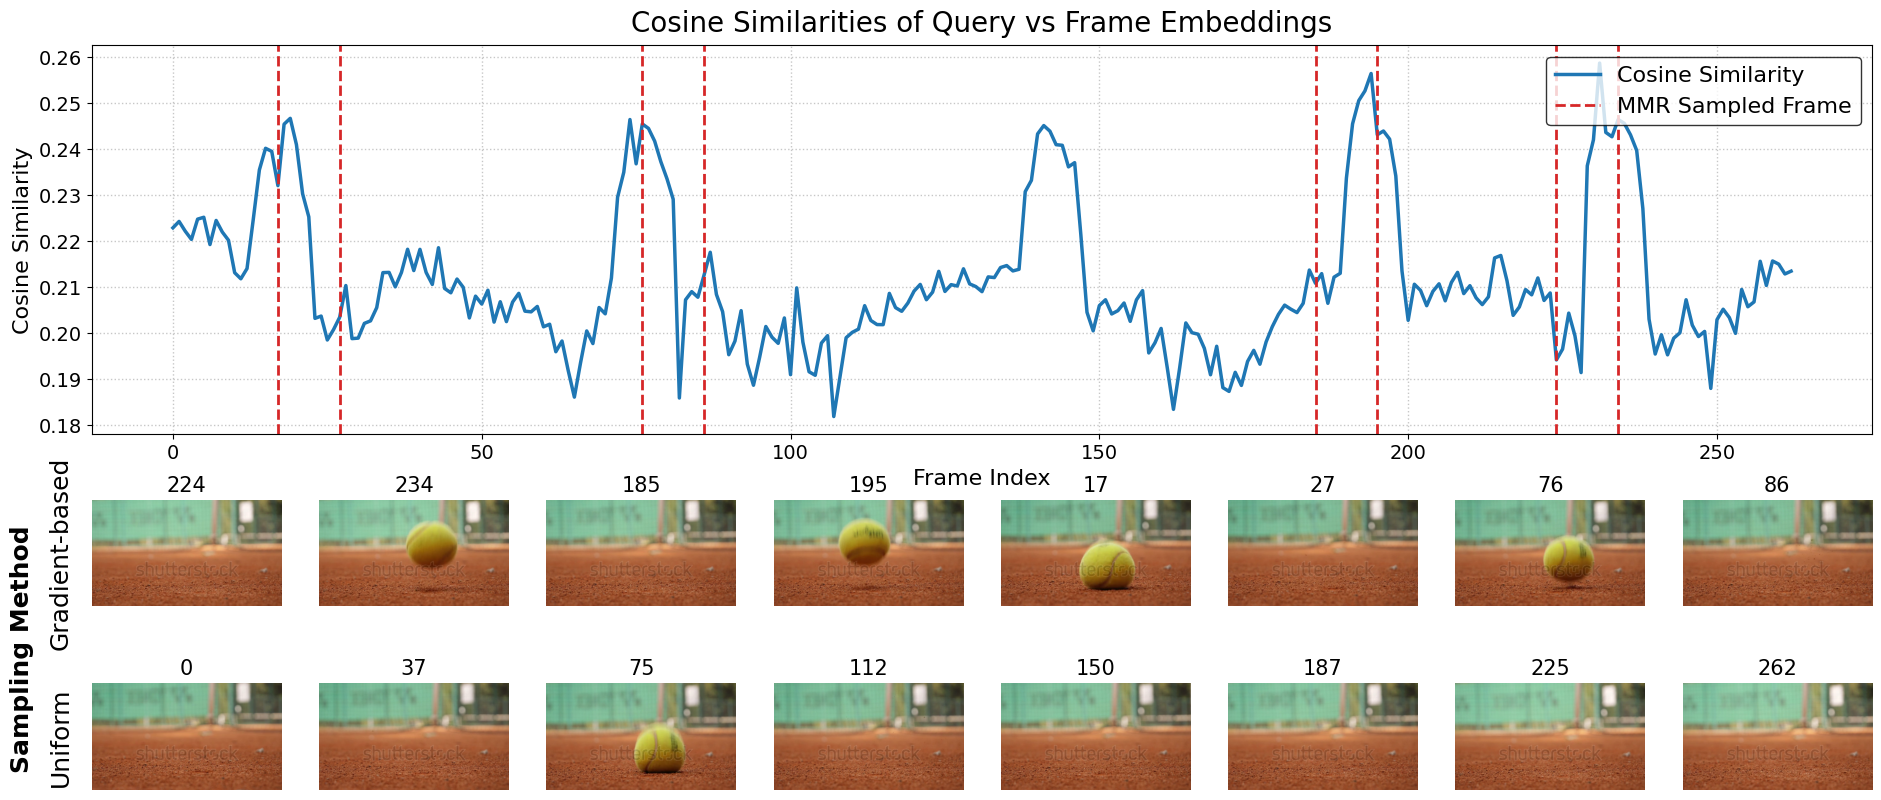

In [15]:
import cv2
cosine_sim = CosineSimilarity(dim=1)


# use Tennis ball video
video_id = "1059632327"
question = "Is the direction of the tennis ball bouncing up and down?"

# video_id = "1095939659"
# question =  ('Which caption matches the video better?\nCaption A: The light is growing clockwise.\nCaption B: The light is growing downwards.', '1095939659')
def load_video_as_tensor(path, max_frames=None):
    cap = cv2.VideoCapture(path)
    frames = []
    count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret or (max_frames and count >= max_frames):
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        frame_tensor = torch.from_numpy(frame).permute(2, 0, 1)  # (C, H, W)
        frames.append(frame_tensor)
        count += 1

    cap.release()
    video_tensor = torch.stack(frames)  # (T, C, H, W)
    return video_tensor

with open('../query_features/CLIP_dictionary_multi_choice.pkl', "rb") as file:
    multi_choice = pickle.load(file)
    
query_embedding = list(multi_choice[video_id]['direction'].values())[0].squeeze(0)
video_embeddings = torch.load('../video_features/' + video_id + '.pt')

# sample 8 frames uniformly
cosine_similarities = cosine_sim(query_embedding, video_embeddings)

video = load_video_as_tensor("videos/" + video_id + ".mp4")


sampled_indices = keypoint_sampling(query_embedding, video_embeddings)
images = video[sampled_indices]
imgs = []

for idx in range(len(sampled_indices)):
    img = images[idx].permute(1, 2, 0).cpu().numpy()  # (H, W, C)
    img = img / 255.0 if img.max() > 1 else img       # normalize if needed
    imgs.append(img)

# Gradient-based sampling
gradient_indices, gradient_points = select_gradient_boundaries(query_embedding, video_embeddings, n_samples=8)
gradient_images = video[gradient_indices]
gradient_imgs = [img.permute(1,2,0).cpu().numpy() / 255.0 if img.max() > 1 else img.permute(1,2,0).cpu().numpy() for img in gradient_images]

# MMR
mmr_indices = dani_sampling(query_embedding, video_embeddings)
mmr_images = video[mmr_indices]
mmr_imgs = [img.permute(1,2,0).cpu().numpy() / 255.0 if img.max() > 1 else img.permute(1,2,0).cpu().numpy() for img in mmr_images]

# Uniform
uniform_indices = uniform_sampling(video_embeddings)
uniform_images = video[uniform_indices]
uniform_imgs = [img.permute(1,2,0).cpu().numpy() / 255.0 if img.max() > 1 else img.permute(1,2,0).cpu().numpy() for img in uniform_images]

# ITS / BOLT
# its_indices = inverse_transform_sampling(query_embedding, video_embeddings, 8)
# its_images = video[its_indices]
# its_imgs = [img.permute(1,2,0).cpu().numpy() / 255.0 if img.max() > 1 else img.permute(1,2,0).cpu().numpy() for img in its_images]

# # Keypoint
# keypoint_indices = keypoint_sampling(query_embedding, video_embeddings)
# keypoint_images = video[keypoint_indices]
# keypoint_imgs = [img.permute(1,2,0).cpu().numpy() / 255.0 if img.max() > 1 else img.permute(1,2,0).cpu().numpy() for img in keypoint_images]


# plot_cosine_similarity_with_frames(
#     video_id,
#     cosine_similarities,
#     mmr_indices=mmr_indices,           # from dani_sampling
#     mmr_images=mmr_imgs,                       # from dani_sampling
#     uniform_indices=uniform_indices, # from uniform_sampling
#     uniform_images=uniform_imgs,             # from uniform_sampling
#     # save_path=f"cosine_similarity_{video_id}_mmr_vs_uniform.pdf"
# )

plot_cosine_similarity_with_frames(
    1059632327,
    cosine_similarities,
    mmr_indices=gradient_indices,           # from gradient sampling
    mmr_images=gradient_imgs,                       # from gradient sampling
    uniform_indices=uniform_indices, # from uniform_sampling
    uniform_images=uniform_imgs,             # from uniform_sampling
    # save_path=f"cosine_similarity_{video_id}_mmr_vs_uniform.pdf"
)

In [6]:
def plot_all_sampling_methods(video_id, its_indices, its_imgs, mmr_indices, mmr_imgs, keypoint_indices, keypoint_imgs, uniform_indices, uniform_imgs, save_path=None):
    """
    Plot rows of images for each frame sampling method: ITS, MMR, Keypoint, Uniform.
    """
    methods = [
        ("ITS", its_indices, its_imgs),
        ("MMR", mmr_indices, mmr_imgs),
        ("Keypoint", keypoint_indices, keypoint_imgs),
        ("Uniform", uniform_indices, uniform_imgs),
    ]
    n_methods = len(methods)
    n_imgs = len(its_imgs)
    fig = plt.figure(figsize=(2.5 * n_imgs, 2.2 * n_methods))
    gs = gridspec.GridSpec(n_methods, n_imgs, hspace=0.08)

    for row, (label, indices, imgs) in enumerate(methods):
        for col, img in enumerate(imgs):
            ax_img = plt.subplot(gs[row, col])
            ax_img.imshow(img)
            ax_img.axis("off")
            ax_img.set_title(f"{indices[col]}", fontsize=13, pad=6)
            ax_img.title.set_position([.5, -0.25])
            if col == 0:
                ax_img.text(-0.55, 0.5, label, fontsize=16, fontweight='bold',
                            va='center', ha='center', rotation=90, transform=ax_img.transAxes)

    # Add 'sampling method' label on the far left, centered
    fig.text(
        0.015, 0.5, "sampling method", fontsize=16, fontweight='bold',
        va='center', ha='center', rotation=90
    )

    plt.tight_layout()
    plt.subplots_adjust(left=0.09, right=0.98, top=0.97, bottom=0.08)
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        plt.close(fig)
    else:
        plt.show()

# ITS
its_indices = inverse_transform_sampling(query_embedding, video_embeddings, n_samples=8)
its_images = video[its_indices]
its_imgs = [img.permute(1,2,0).cpu().numpy() / 255.0 if img.max() > 1 else img.permute(1,2,0).cpu().numpy() for img in its_images]
keypoint_indices = keypoint_sampling(query_embedding, video_embeddings)
keypoint_images = video[keypoint_indices]
keypoint_imgs = [img.permute(1,2,0).cpu().numpy() / 255.0 if img.max() > 1 else img.permute(1,2,0).cpu().numpy() for img in keypoint_images]
save_path = f"all_sampling_methods_{video_id}.pdf"

plot_all_sampling_methods(
    video_id,
    its_indices, its_imgs,
    mmr_indices, mmr_imgs,
    keypoint_indices, keypoint_imgs,
    uniform_indices, uniform_imgs
)

TypeError: min() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (Tensor other)
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


/scratch-local/62814/ipykernel_3246228/3458684790.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


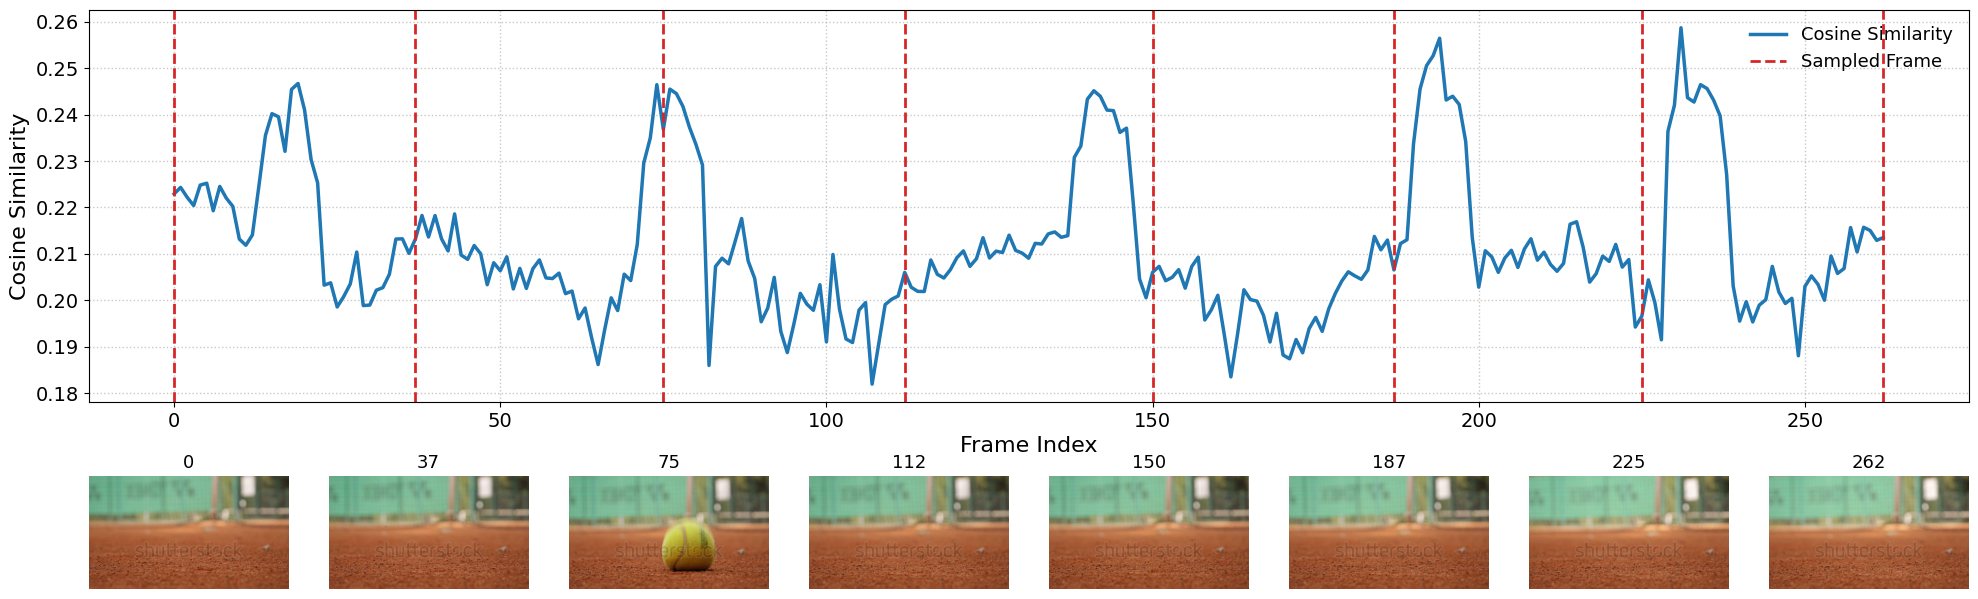

In [ ]:
sampled_indices = uniform_sampling(video_embeddings)
images = video[sampled_indices]
imgs = []

for idx in range(len(sampled_indices)):
    img = images[idx].permute(1, 2, 0).cpu().numpy()  # (H, W, C)
    img = img / 255.0 if img.max() > 1 else img       # normalize if needed
    imgs.append(img)

plot_cosine_similarity_with_frames(
    video_id, cosine_similarities, sampled_indices, imgs,
    save_path=f"cosine_similarity_{video_id}_uniform.pdf"
)